In [1]:
import sys; sys.path.append("..") 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Model

from src.utility import *
from src.dataprocessing import *
from src import rnn

# Data

## load data

In [2]:
# Define variables
input_var   = ["FT-3061-2", "FT-3061-3", "FT-3061-4", "FT-3062-1"]
output_var  = ["TT-3061-3", "TT-3061-4", "LT-3061-2"]
process_var = input_var + output_var

In [3]:
min_len = 200
continuous_path = './data/3_continuous'

cts_list = []
i = 1
while exists(continuous_path, f"cts_{min_len}/dataset {min_len}_{i}", 'csv'):
    cts_df = loadfile(continuous_path, f"cts_{min_len}/dataset {min_len}_{i}", 'csv')
    cts_list.append(cts_df)
    i += 1

csv file is loaded from ./data/3_continuous/cts_200/dataset 200_1.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_2.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_3.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_4.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_5.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_6.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_7.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_8.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_9.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_10.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_11.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_12.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_13.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_14.csv
csv file is loa

## data to series

In [4]:
target_list = cts_list

history_size = 60
future_size = 20
step = 1

history_var = process_var
future_var = output_var

history_num = len(history_var)
future_num = len(future_var)

history_series = []
future_series = []

for i in range(len(target_list)):
    history, future = data2series(target_list[i], history_size, history_var, future_size, future_var,
                                  step, start_idx=0, end_idx=None)
    if not i:
        history_series = history
        future_series = future
    else:
        history_series = np.concatenate([history_series, history], axis=0)
        future_series = np.concatenate([future_series, future], axis=0)

print(history_series.shape)
print(future_series.shape)

(29453, 60, 7)
(29453, 20, 3)


## supervised attention

delta 1


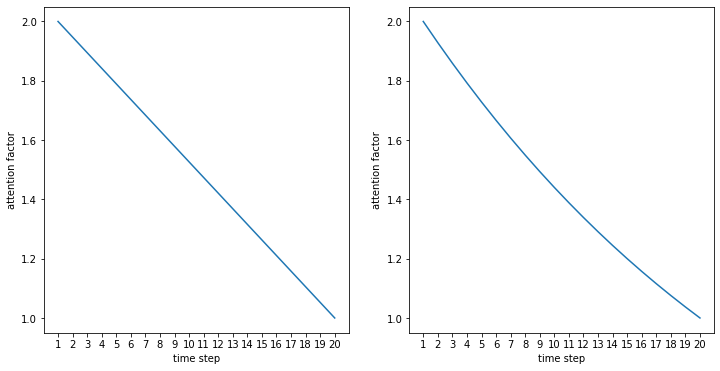

delta 5


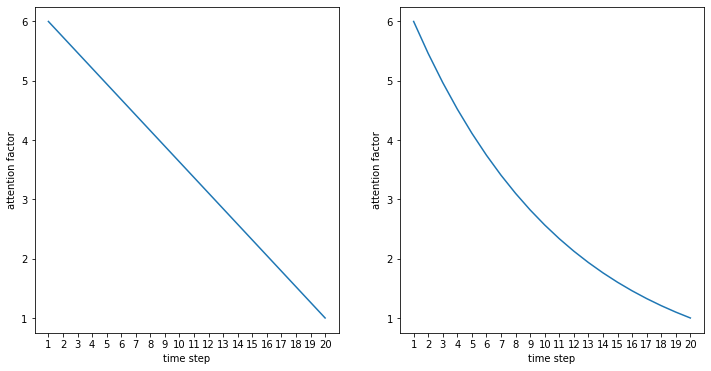

delta 10


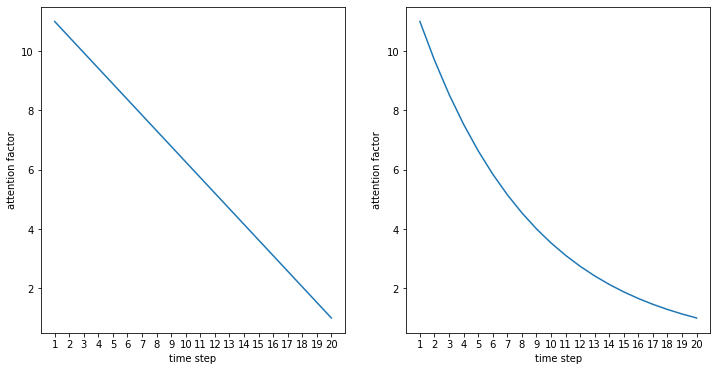

In [5]:
delta_list = [1,5,10]
for delta in delta_list:
    linear_attention = rnn.super_attention(delta, future_size, future_num, 'linear')
    exp_attention = rnn.super_attention(delta, future_size, future_num, 'exp')
    
    print(f"delta {delta}")
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    plt.plot([x for x in range(1,future_size+1)], linear_attention[0,:,0])
    plt.xlabel("time step")
    plt.xticks([x for x in range(1,future_size+1)])
    plt.ylabel("attention factor")
    
    plt.subplot(1,2,2)
    plt.plot([x for x in range(1,future_size+1)], exp_attention[0,:,0])
    plt.xlabel("time step")
    plt.xticks([x for x in range(1,future_size+1)])
    plt.ylabel("attention factor")
    
    plt.show()

# Build model

## seq2seq model

In [6]:
# supervised attention factor 생성
delta = 1
att_type = 'linear'
factor = rnn.super_attention(delta, future_size, future_num, att_type)

# RNN class 생성
seq2seq_GRU = rnn.RNN(history_series, history_var, future_series, future_var)

# 테스트 데이터 스플릿
test_size = 0.2
test_num = -1
seq2seq_GRU.train_test(test_size=test_size, test_num=test_num)

# 검증 데이터 스플릿
valid_size = seq2seq_GRU.history_test.shape[0]/seq2seq_GRU.history_train.shape[0]
seq2seq_GRU.train_valid(valid_size=valid_size)

# 데이터 스케일링
seq2seq_GRU.scaling()

# 모델 구성
num_layers = 1
num_neurons = 50
dense_layers = 1
dense_neurons = 50
model_type = 'seq2seq_gru'
seq2seq_GRU.build_model(num_layers=num_layers, num_neurons=num_neurons, dense_layers=dense_layers, dense_neurons=dense_neurons, model_type=model_type)
print(seq2seq_GRU.model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 7)]      0           []                               
                                                                                                  
 encoder (GRU)                  [(None, 50),         8850        ['input_1[0][0]']                
                                 (None, 50)]                                                      
                                                                                                  
 repeat_vector (RepeatVector)   (None, 20, 50)       0           ['encoder[0][0]']                
                                                                                                  
 decoder (GRU)                  (None, 20, 50)       15300       ['repeat_vector[0][0]',      

In [7]:
model_num = 'test'
model_name = f"{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{model_num}"

if not exists("./model", model_name, 'model'):
    seq2seq_GRU.train()
    seq2seq_GRU.save_model(f"./model/{model_name}")
else:
    seq2seq_GRU.model = loadfile("./model", model_name, 'model')

model is loaded from: ./model/1_50_1_50_seq2seq_gru_test


In [8]:
seq2seq_GRU.test()

,TT-3061-3,TT-3061-4,LT-3061-2,TT-3061-3,TT-3061-4,LT-3061-2
index,R2,R2,R2,nRMSE,nRMSE,nRMSE
0,0.863038,0.253702,0.861348,7.380769,11.050266,5.657549
1,0.764506,0.324383,0.788122,9.503999,10.513772,6.996596
2,0.632053,0.331833,0.690113,11.36166,10.456642,8.465243
3,0.491815,0.266435,0.636485,12.906194,10.95823,9.172404
4,0.351911,0.164389,0.613148,14.341778,11.697985,9.466241
5,0.234427,0.081991,0.614805,15.535539,12.264171,9.449139
6,0.139787,0.037682,0.617663,16.145331,12.560198,9.416956
7,0.059328,0.02694,0.600908,16.56054,12.633877,9.623408
8,-0.012265,0.027812,0.553069,16.926368,12.631351,10.18537


## attention model

In [9]:
# supervised attention factor 생성
delta = 1
att_type = 'linear'
factor = rnn.super_attention(delta, future_size, future_num, att_type)

# RNN class 생성
ATT_seq2seq_GRU = rnn.RNN(history_series, history_var, future_series, future_var)

# 테스트 데이터 스플릿
test_size = 0.2
test_num = -1
ATT_seq2seq_GRU.train_test(test_size=test_size, test_num=test_num)

# 검증 데이터 스플릿
valid_size = ATT_seq2seq_GRU.history_test.shape[0]/ATT_seq2seq_GRU.history_train.shape[0]
ATT_seq2seq_GRU.train_valid(valid_size=valid_size)

# 데이터 스케일링
ATT_seq2seq_GRU.scaling()

# 모델 구성
num_layers = 1
num_neurons = 50
dense_layers = 1
dense_neurons = 50
model_type = 'att_seq2seq_gru'
ATT_seq2seq_GRU.build_model(num_layers=num_layers, num_neurons=num_neurons, dense_layers=dense_layers, dense_neurons=dense_neurons, model_type=model_type, factor=factor)
print(ATT_seq2seq_GRU.model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 60, 7)]      0           []                               
                                                                                                  
 encoder (GRU)                  [(None, 60, 50),     8850        ['input_2[0][0]']                
                                 (None, 50)]                                                      
                                                                                                  
 repeat_vector_1 (RepeatVector)  (None, 20, 50)      0           ['encoder[0][1]']                
                                                                                                  
 decoder (GRU)                  (None, 20, 50)       15300       ['repeat_vector_1[0][0]',  

In [10]:
model_num = 'test'
model_name = f"{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{model_num}"

if not exists("./model", model_name, 'model'):
    ATT_seq2seq_GRU.train()
    ATT_seq2seq_GRU.save_model(f"./model/{model_name}")
else:
    ATT_seq2seq_GRU.model = loadfile("./model", model_name, 'model')

model is loaded from: ./model/1_50_1_50_att_seq2seq_gru_test


In [11]:
ATT_seq2seq_GRU.test()

,TT-3061-3,TT-3061-4,LT-3061-2,TT-3061-3,TT-3061-4,LT-3061-2
index,R2,R2,R2,nRMSE,nRMSE,nRMSE
0,0.870494,0.35303,0.908175,7.177062,10.288658,4.604105
1,0.810554,0.385528,0.870703,8.524302,10.026736,5.465611
2,0.738743,0.311884,0.842395,9.573772,10.611588,6.037013
3,0.663862,0.255848,0.8269,10.496536,11.037023,6.329509
4,0.586419,0.210446,0.819406,11.456865,11.371035,6.467811
5,0.510147,0.175462,0.810231,12.426991,11.623052,6.632314
6,0.436783,0.154708,0.795371,13.064172,11.771737,6.889238
7,0.369061,0.137325,0.775388,13.562788,11.895715,7.219538
8,0.308993,0.119992,0.750911,13.984853,12.017608,7.603856


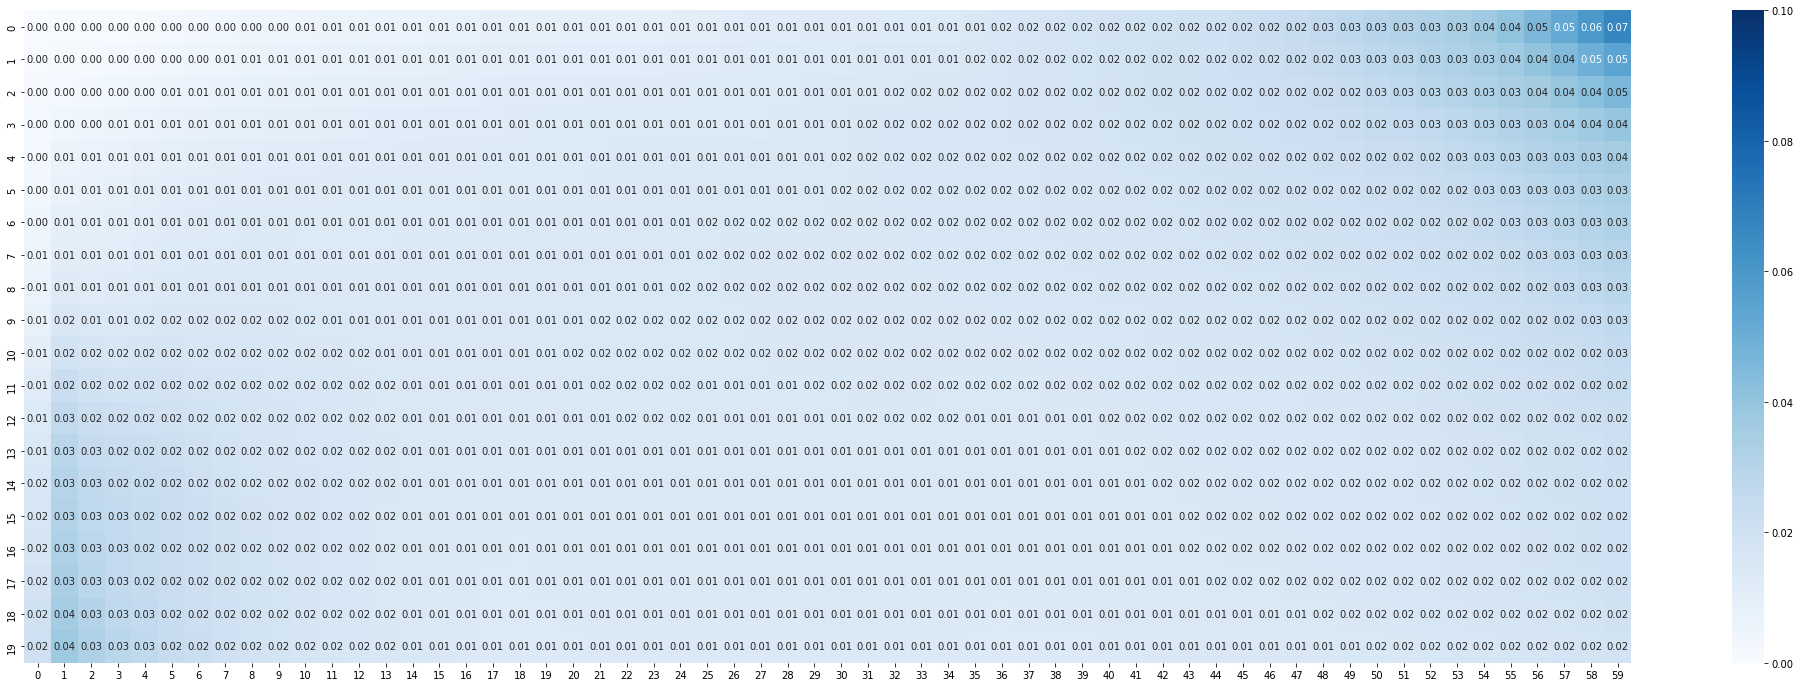

In [12]:
attention = ATT_seq2seq_GRU.get_attention(ATT_seq2seq_GRU.history_test_sc)
attention_mean = attention.mean(axis=0)
attention_std = attention.std(axis=0)

plt.figure(figsize=(36,12))
ax = sns.heatmap(attention_mean, cmap='Blues', vmin=0, vmax=0.1, annot=True, fmt='.2f')

## dual attention model

In [13]:
# supervised attention factor 생성
delta = 1
att_type = 'linear'
factor = rnn.super_attention(delta, future_size, future_num, att_type)

# RNN class 생성
DATT_seq2seq_GRU = rnn.RNN(history_series, history_var, future_series, future_var)

# 테스트 데이터 스플릿
test_size = 0.2
test_num = -1
DATT_seq2seq_GRU.train_test(test_size=test_size, test_num=test_num)

# 검증 데이터 스플릿
valid_size = DATT_seq2seq_GRU.history_test.shape[0]/DATT_seq2seq_GRU.history_train.shape[0]
DATT_seq2seq_GRU.train_valid(valid_size=valid_size)

# 데이터 스케일링
DATT_seq2seq_GRU.scaling()

# 모델 구성
num_layers = 1
num_neurons = 50
dense_layers = 1
dense_neurons = 50
model_type = 'datt_seq2seq_gru'
DATT_seq2seq_GRU.build_model(num_layers=num_layers, num_neurons=num_neurons, dense_layers=dense_layers, dense_neurons=dense_neurons, model_type=model_type, factor=factor)
print(DATT_seq2seq_GRU.model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 60, 7)]      0           []                               
                                                                                                  
 encoder (GRU)                  [(None, 60, 50),     8850        ['input_3[0][0]']                
                                 (None, 50)]                                                      
                                                                                                  
 repeat_vector_2 (RepeatVector)  (None, 20, 50)      0           ['encoder[0][1]']                
                                                                                                  
 decoder (GRU)                  (None, 20, 50)       15300       ['repeat_vector_2[0][0]',  

In [14]:
model_num = 'test'
model_name = f"{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{model_num}"

if not exists("./model", model_name, 'model'):
    DATT_seq2seq_GRU.train()
    DATT_seq2seq_GRU.save_model(f"./model/{model_name}")
else:
    DATT_seq2seq_GRU.model = loadfile("./model", model_name, 'model')

model is loaded from: ./model/1_50_1_50_datt_seq2seq_gru_test


In [15]:
DATT_seq2seq_GRU.test()

,TT-3061-3,TT-3061-4,LT-3061-2,TT-3061-3,TT-3061-4,LT-3061-2
index,R2,R2,R2,nRMSE,nRMSE,nRMSE
0,0.889587,0.48964,0.907113,6.626931,9.138081,4.630646
1,0.818678,0.548839,0.882296,8.339531,8.591607,5.214817
2,0.728809,0.504011,0.832683,9.75408,9.009193,6.220243
3,0.63573,0.463628,0.784093,10.926956,9.370315,7.068956
4,0.54808,0.42763,0.739339,11.976127,9.681605,7.770398
5,0.463371,0.394508,0.697164,13.006788,9.96022,8.378299
6,0.38179,0.361044,0.654659,13.687115,10.234647,8.949757
7,0.305234,0.320269,0.611845,14.232287,10.55931,9.490636
8,0.238296,0.272722,0.566696,14.682828,10.925086,10.028887


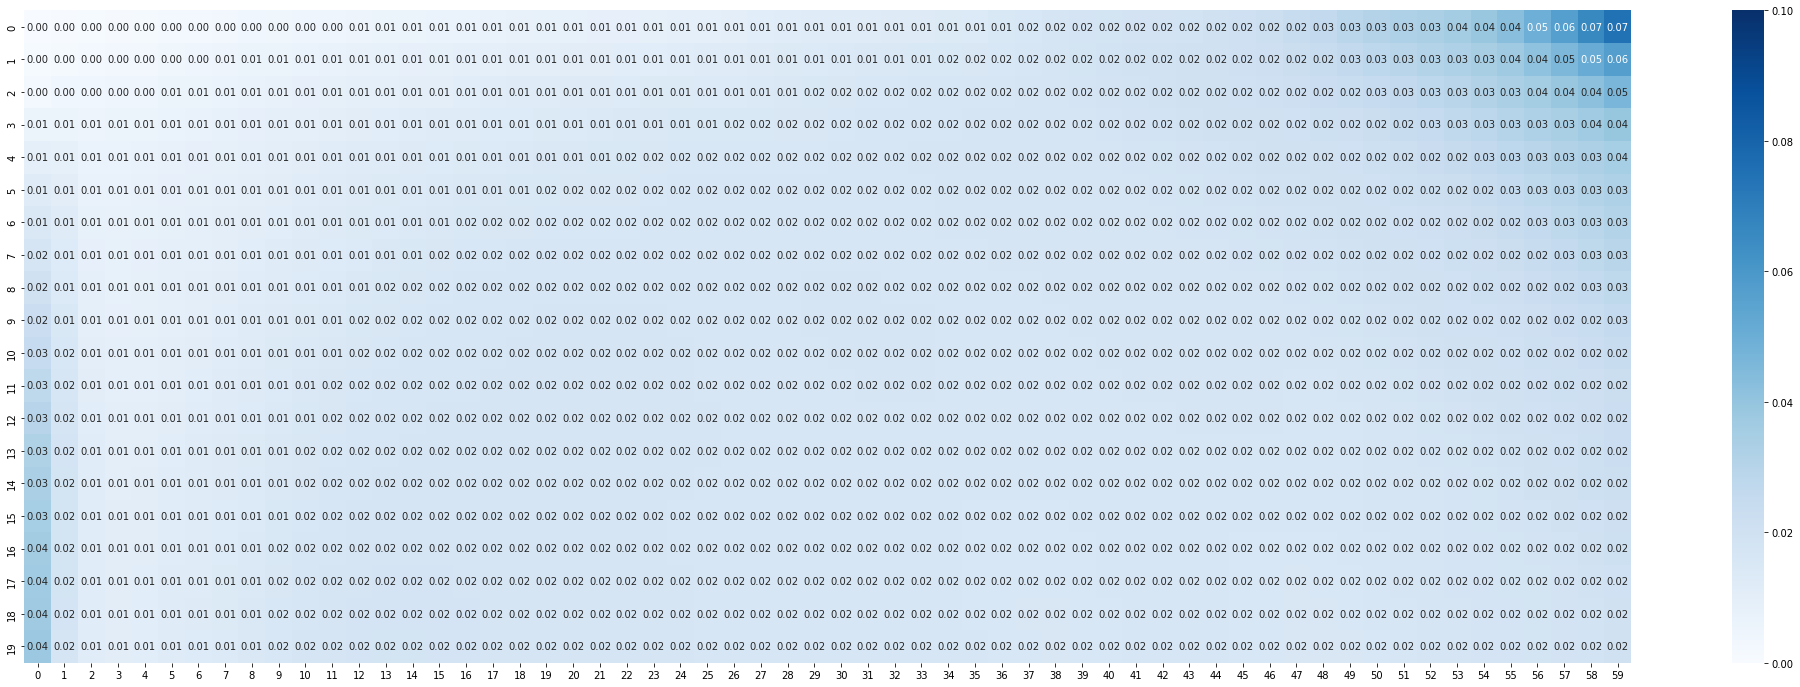

In [16]:
attention = DATT_seq2seq_GRU.get_attention(DATT_seq2seq_GRU.history_test_sc)
attention_mean = attention.mean(axis=0)
attention_std = attention.std(axis=0)

plt.figure(figsize=(36,12))
ax = sns.heatmap(attention_mean, cmap='Blues', vmin=0, vmax=0.1, annot=True, fmt='.2f')